In [ ]:
import pandas as pd
from scipy import stats

# Assuming your DataFrame is named 'df'
# and the column containing patient state is '!Sample_characteristics_ch1'

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel('/content/COLAB.xlsx')

              t_statistic        p_value
MIMAT0000062    36.033509  2.357702e-244
MIMAT0000063    33.591969  1.874481e-216
MIMAT0000064    39.411021  1.863299e-284
MIMAT0000065    31.031257  2.443733e-188
MIMAT0000066    35.235712  3.962405e-235
...                   ...            ...
MIMAT0032116    20.987467   1.509206e-92
MIMAT0033692    -6.196976   6.379709e-10
MIMAT0035542     2.145455   3.198063e-02
MIMAT0035703    27.635327  3.856013e-153
MIMAT0035704    45.162452   0.000000e+00

[2565 rows x 2 columns]


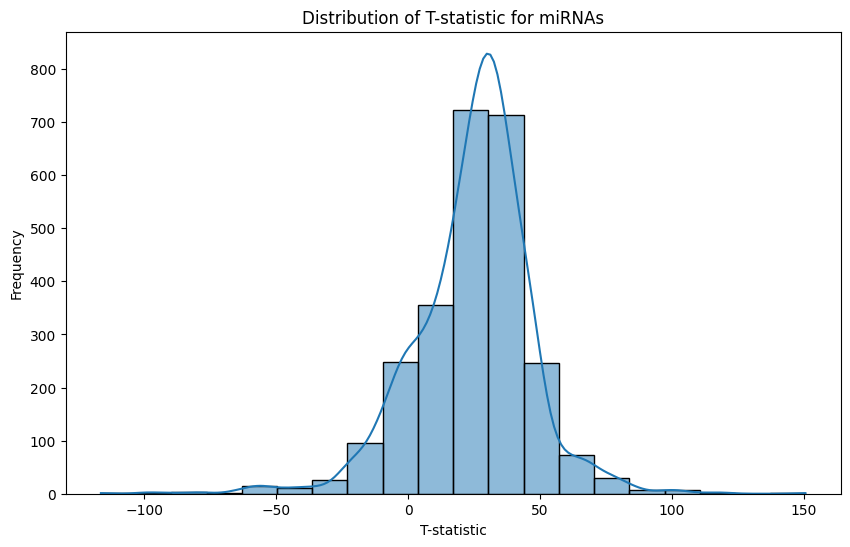

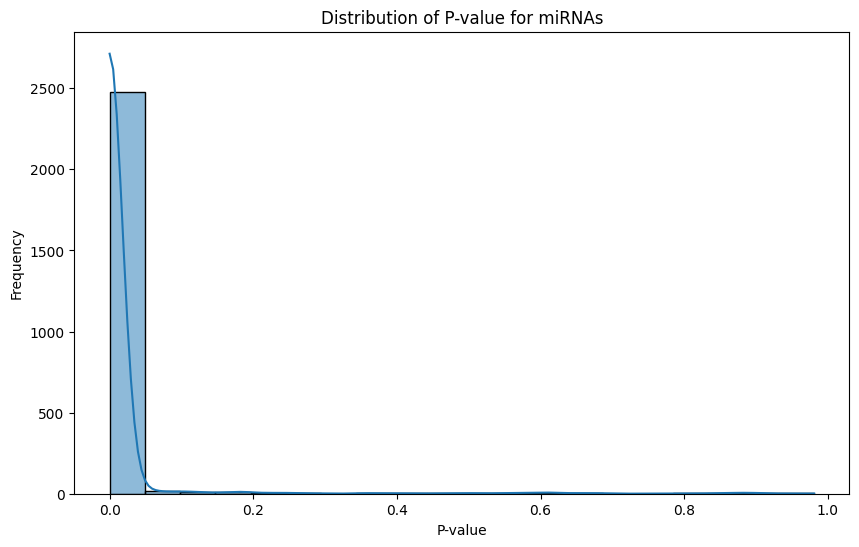

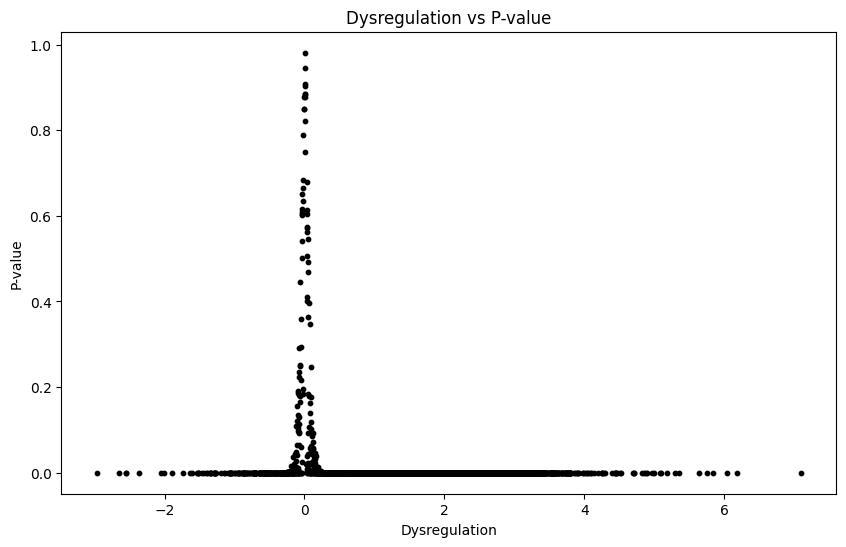

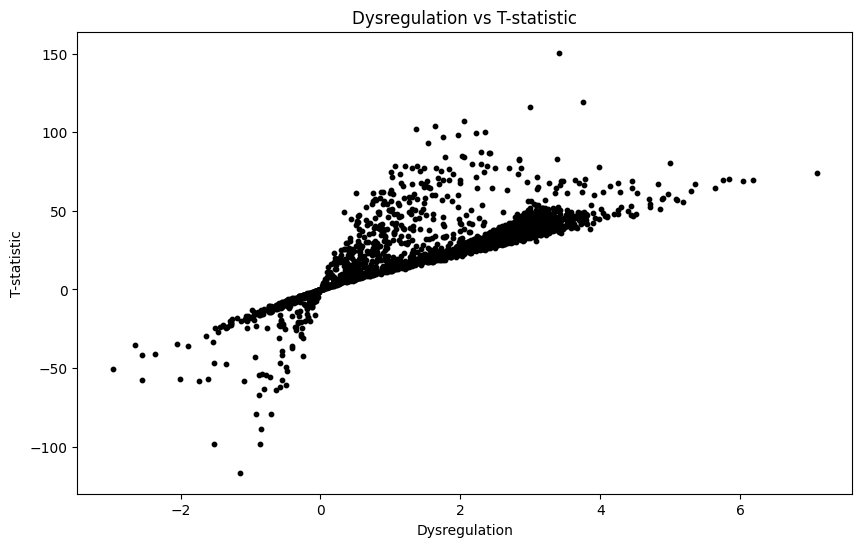

High Dysregulation miRNAs:
                           miRNA  Dysregulation
0                   MIMAT0000062       3.443682
1                   MIMAT0000063       3.039156
2                   MIMAT0000064       3.663450
3                   MIMAT0000065       3.080802
4                   MIMAT0000066       3.083259
...                          ...            ...
2556                MIMAT0032026       2.479584
2558                MIMAT0032110       1.665235
2559  MIMAT0032114, MIMAT0032115       2.408537
2563                MIMAT0035703       2.073242
2564                MIMAT0035704       3.321393

[1818 rows x 2 columns]

Low Dysregulation miRNAs:
             miRNA  Dysregulation
46    MIMAT0000228       0.720546
47    MIMAT0000231       0.710762
66    MIMAT0000262       0.816324
67    MIMAT0000263       0.821676
119   MIMAT0000447       0.948976
...            ...            ...
2522  MIMAT0030997       0.889874
2523  MIMAT0030998      -0.761751
2541  MIMAT0031016       0.388706
2545 

In [ ]:
# Separate the data into two groups
lung_cancer_group = df[df['!Sample_characteristics_ch1'] == 'disease state: Lung cancer, pre-operation']
control_group = df[df['!Sample_characteristics_ch1'] == 'disease state: Non-cancer control']

# Get the list of miRNA columns
miRNA_columns = df.columns[df.columns.str.startswith('MIMAT')]  # Assuming miRNA IDs start with 'MIMAT'

average_sick = lung_cancer_group[miRNA_columns].mean()
average_healthy = control_group[miRNA_columns].mean()

# Calculate the dysregulation (average_sick / average_healthy)
dysregulation = average_sick - average_healthy

# Create a DataFrame to store the results
dysregulation_df = pd.DataFrame({'miRNA': dysregulation.index, 'Dysregulation': dysregulation.values})

# Perform t-test for each miRNA column
results = {}
for column in miRNA_columns:
    t_statistic, p_value = stats.ttest_ind(lung_cancer_group[column], control_group[column], nan_policy='omit')  # Handle missing values
    results[column] = {'t_statistic': t_statistic, 'p_value': p_value}

# Create a DataFrame to store the results
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
print(results_df)

import matplotlib.pyplot as plt
import seaborn as sns

# T-statistic distribution
plt.figure(figsize=(10, 6))
sns.histplot(results_df['t_statistic'], kde=True, bins=20)
plt.title('Distribution of T-statistic for miRNAs')
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.show()

# P-value distribution
plt.figure(figsize=(10, 6))
sns.histplot(results_df['p_value'], kde=True, bins=20)
plt.title('Distribution of P-value for miRNAs')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

import matplotlib.pyplot as plt

# Create a new DataFrame combining dysregulation and statistical results
plot_df = pd.DataFrame({'Dysregulation': dysregulation, 'p_value': results_df['p_value'], 't_statistic': results_df['t_statistic']})
plot_df.index = results_df.index  # Set index to miRNA names

# Scatter plot for dysregulation vs p-value
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Dysregulation'], plot_df['p_value'], c='black', s=10)
plt.xlabel('Dysregulation')
plt.ylabel('P-value')
plt.title('Dysregulation vs P-value')
plt.show()

# Scatter plot for dysregulation vs t-statistic
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Dysregulation'], plot_df['t_statistic'], c='black', s=10)
plt.xlabel('Dysregulation')
plt.ylabel('T-statistic')
plt.title('Dysregulation vs T-statistic')
plt.show()

p_value_threshold = 0.001
t_statistic_threshold_positive = 10
t_statistic_threshold_negative = -10

# 1. Filter based on probability thresholds (p-value and t-statistic)
filtered_miRNAs_by_probability = results_df[
    (results_df['p_value'] < p_value_threshold) &
    ((results_df['t_statistic'] > t_statistic_threshold_positive) |
     (results_df['t_statistic'] < t_statistic_threshold_negative))
]

# 2. Get the miRNA names that passed the probability filter
filtered_miRNA_names = filtered_miRNAs_by_probability.index

# 3. Filter dysregulation_df based on the filtered miRNA names
filtered_dysregulation_df = dysregulation_df[dysregulation_df['miRNA'].isin(filtered_miRNA_names)]

# 4. Set thresholds for dysregulation
high_threshold = 1.0
low_threshold = 0.15
no_dysregulation_threshold = 0.15

# 5. Separate data into dysregulation groups
high_dysregulation_miRNAs = filtered_dysregulation_df[
    (filtered_dysregulation_df['Dysregulation'] >= high_threshold) |
    (filtered_dysregulation_df['Dysregulation'] <= -high_threshold)
]
low_dysregulation_miRNAs = filtered_dysregulation_df[
    (filtered_dysregulation_df['Dysregulation'] < high_threshold) &
    (filtered_dysregulation_df['Dysregulation'] > -high_threshold) &
    ((filtered_dysregulation_df['Dysregulation'] >= low_threshold) |
    (filtered_dysregulation_df['Dysregulation'] <= -low_threshold))

]
no_dysregulation_miRNAs = filtered_dysregulation_df[
    (filtered_dysregulation_df['Dysregulation'] < low_threshold) &
    (filtered_dysregulation_df['Dysregulation'] > -low_threshold)
   # ((filtered_dysregulation_df['Dysregulation'] >= no_dysregulation_threshold) |
   # (filtered_dysregulation_df['Dysregulation'] <= -no_dysregulation_threshold))
]


# Print the results
print("High Dysregulation miRNAs:")
print(high_dysregulation_miRNAs)

print("\nLow Dysregulation miRNAs:")
print(low_dysregulation_miRNAs)

print("\nNo Dysregulation miRNAs:")
print(no_dysregulation_miRNAs)


In [ ]:
# Separate the data into two groups
lung_cancer_group = df[df['!Sample_characteristics_ch1'] == 'disease state: Lung cancer, pre-operation']
control_group = df[df['!Sample_characteristics_ch1'] == 'disease state: Non-cancer control']

# Get the list of miRNA columns
miRNA_columns = df.columns[df.columns.str.startswith('MIMAT')]  # Assuming miRNA IDs start with 'MIMAT'

average_sick = lung_cancer_group[miRNA_columns].mean()
average_healthy = control_group[miRNA_columns].mean()

# Calculate the dysregulation (average_sick / average_healthy)
dysregulation = average_sick - average_healthy

# Create a DataFrame to store the results
dysregulation_df = pd.DataFrame({'miRNA': dysregulation.index, 'Dysregulation': dysregulation.values})

# Perform t-test for each miRNA column
results = {}
for column in miRNA_columns:
    t_statistic, p_value = stats.ttest_ind(lung_cancer_group[column], control_group[column], nan_policy='omit')  # Handle missing values
    results[column] = {'t_statistic': t_statistic, 'p_value': p_value}

# Create a DataFrame to store the results
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the results DataFrame
print(results_df)


              t_statistic        p_value
MIMAT0000062    36.033509  2.357702e-244
MIMAT0000063    33.591969  1.874481e-216
MIMAT0000064    39.411021  1.863299e-284
MIMAT0000065    31.031257  2.443733e-188
MIMAT0000066    35.235712  3.962405e-235
...                   ...            ...
MIMAT0032116    20.987467   1.509206e-92
MIMAT0033692    -6.196976   6.379709e-10
MIMAT0035542     2.145455   3.198063e-02
MIMAT0035703    27.635327  3.856013e-153
MIMAT0035704    45.162452   0.000000e+00

[2565 rows x 2 columns]


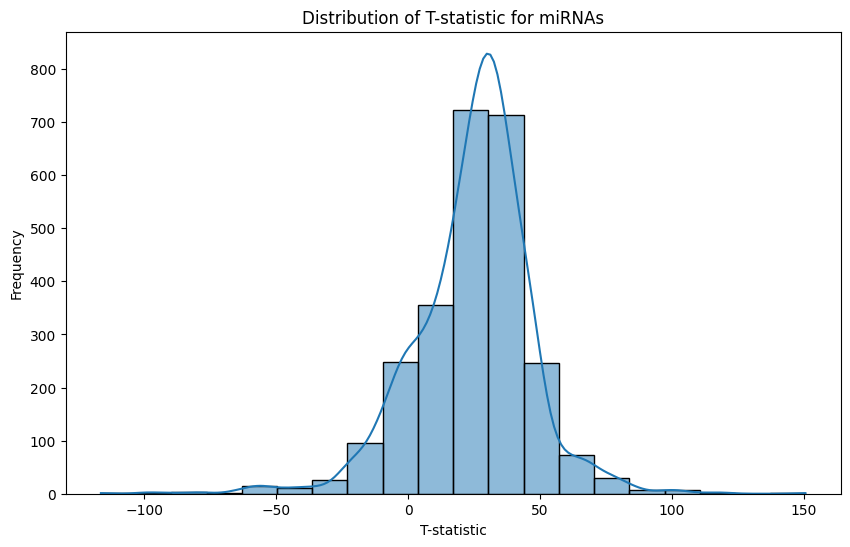

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# T-statistic distribution
plt.figure(figsize=(10, 6))
sns.histplot(results_df['t_statistic'], kde=True, bins=20)
plt.title('Distribution of T-statistic for miRNAs')
plt.xlabel('T-statistic')
plt.ylabel('Frequency')
plt.show()


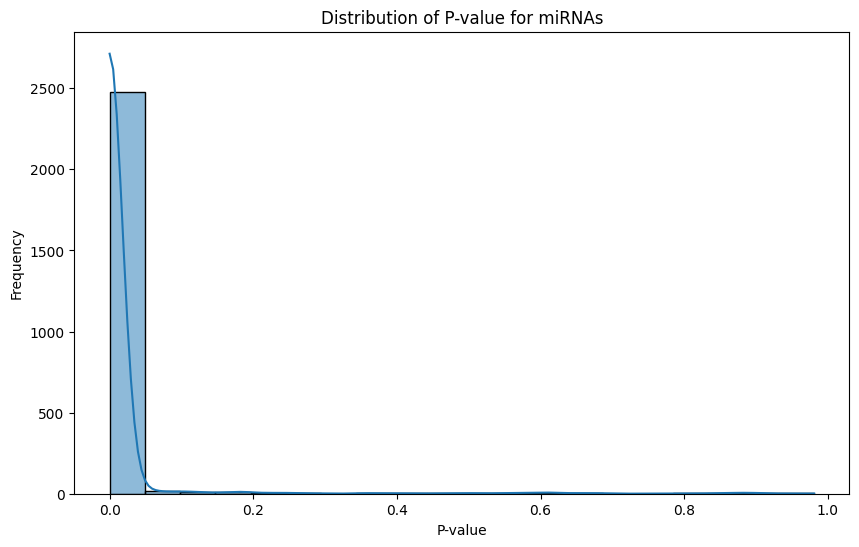

In [ ]:
# P-value distribution
plt.figure(figsize=(10, 6))
sns.histplot(results_df['p_value'], kde=True, bins=20)
plt.title('Distribution of P-value for miRNAs')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()


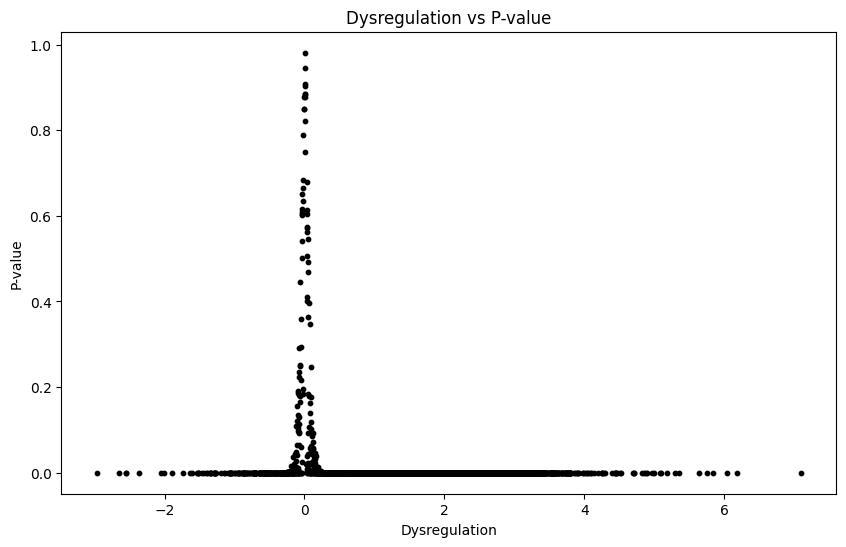

In [ ]:
import matplotlib.pyplot as plt

# Create a new DataFrame combining dysregulation and statistical results
plot_df = pd.DataFrame({'Dysregulation': dysregulation, 'p_value': results_df['p_value'], 't_statistic': results_df['t_statistic']})
plot_df.index = results_df.index  # Set index to miRNA names

# Scatter plot for dysregulation vs p-value
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Dysregulation'], plot_df['p_value'], c='black', s=10)
plt.xlabel('Dysregulation')
plt.ylabel('P-value')
plt.title('Dysregulation vs P-value')
plt.show()


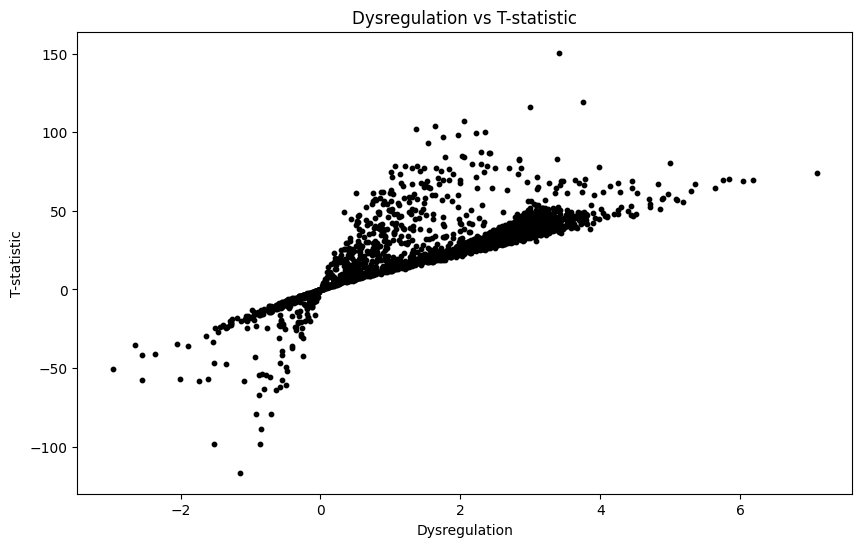

In [ ]:
# Scatter plot for dysregulation vs t-statistic
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Dysregulation'], plot_df['t_statistic'], c='black', s=10)
plt.xlabel('Dysregulation')
plt.ylabel('T-statistic')
plt.title('Dysregulation vs T-statistic')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 1. Prepare the data for modeling

# --- Model 1: High Dysregulation miRNAs ---
selected_columns_model1 = high_dysregulation_miRNAs['miRNA'].tolist() + ['!Sample_characteristics_ch1']
data_for_model1 = df[selected_columns_model1]
X_model1 = data_for_model1[high_dysregulation_miRNAs['miRNA'].tolist()]
y_model1 = data_for_model1['!Sample_characteristics_ch1']
X_train_model1, X_test_model1, y_train_model1, y_test_model1 = train_test_split(X_model1, y_model1, test_size=0.2, random_state=42)

# --- Model 2: Low Dysregulation miRNAs ---
selected_columns_model2 = low_dysregulation_miRNAs['miRNA'].tolist() + ['!Sample_characteristics_ch1']
data_for_model2 = df[selected_columns_model2]
X_model2 = data_for_model2[low_dysregulation_miRNAs['miRNA'].tolist()]
y_model2 = data_for_model2['!Sample_characteristics_ch1']
X_train_model2, X_test_model2, y_train_model2, y_test_model2 = train_test_split(X_model2, y_model2, test_size=0.2, random_state=42)

# --- Model 3: No Dysregulation miRNAs ---
selected_columns_model3 = no_dysregulation_miRNAs['miRNA'].tolist() + ['!Sample_characteristics_ch1']
data_for_model3 = df[selected_columns_model3]
X_model3 = data_for_model3[no_dysregulation_miRNAs['miRNA'].tolist()]
y_model3 = data_for_model3['!Sample_characteristics_ch1']
X_train_model3, X_test_model3, y_train_model3, y_test_model3 = train_test_split(X_model3, y_model3, test_size=0.2, random_state=42)

# Feature Selection (Top 50 miRNAs)

# --- Model 1 ---
model1_temp = RandomForestClassifier(random_state=42)
model1_temp.fit(X_train_model1, y_train_model1)
importances_model1 = model1_temp.feature_importances_
feature_names_model1 = X_train_model1.columns
feature_importance_df_model1 = pd.DataFrame({'miRNA': feature_names_model1, 'Importance': importances_model1})
top_50_model1 = feature_importance_df_model1.sort_values(by='Importance', ascending=False).head(50)
X_train_model1 = X_train_model1[top_50_model1['miRNA'].tolist()]
X_test_model1 = X_test_model1[top_50_model1['miRNA'].tolist()]

# --- Model 2 ---
model2_temp = RandomForestClassifier(random_state=42)
model2_temp.fit(X_train_model2, y_train_model2)
importances_model2 = model2_temp.feature_importances_
feature_names_model2 = X_train_model2.columns
feature_importance_df_model2 = pd.DataFrame({'miRNA': feature_names_model2, 'Importance': importances_model2})
top_50_model2 = feature_importance_df_model2.sort_values(by='Importance', ascending=False).head(50)
X_train_model2 = X_train_model2[top_50_model2['miRNA'].tolist()]
X_test_model2 = X_test_model2[top_50_model2['miRNA'].tolist()]

# --- Model 3 ---
model3_temp = RandomForestClassifier(random_state=42)
model3_temp.fit(X_train_model3, y_train_model3)
importances_model3 = model3_temp.feature_importances_
feature_names_model3 = X_train_model3.columns
feature_importance_df_model3 = pd.DataFrame({'miRNA': feature_names_model3, 'Importance': importances_model3})
top_50_model3 = feature_importance_df_model3.sort_values(by='Importance', ascending=False).head(50)
X_train_model3 = X_train_model3[top_50_model3['miRNA'].tolist()]
X_test_model3 = X_test_model3[top_50_model3['miRNA'].tolist()]

# 2. Create and train the models (using the reduced feature sets)

# --- Model 1 ---
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_train_model1, y_train_model1)
y_pred_model1 = model1.predict(X_test_model1)

# --- Model 2 ---
model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train_model2, y_train_model2)
y_pred_model2 = model2.predict(X_test_model2)

# --- Model 3 ---
model3 = RandomForestClassifier(random_state=42)
model3.fit(X_train_model3, y_train_model3)
y_pred_model3 = model3.predict(X_test_model3)

# 3. Evaluate the models

# --- Model 1 ---
accuracy_model1 = accuracy_score(y_test_model1, y_pred_model1)
precision_model1 = precision_score(y_test_model1, y_pred_model1, pos_label='disease state: Lung cancer, pre-operation')
recall_model1 = recall_score(y_test_model1, y_pred_model1, pos_label='disease state: Lung cancer, pre-operation')
f1_model1 = f1_score(y_test_model1, y_pred_model1, pos_label='disease state: Lung cancer, pre-operation')
conf_matrix_model1 = confusion_matrix(y_test_model1, y_pred_model1)
class_report_model1 = classification_report(y_test_model1, y_pred_model1)

print("Model 1 Evaluation:")
print("Accuracy:", accuracy_model1)
print("Precision:", precision_model1)
print("Recall:", recall_model1)
print("F1-score:", f1_model1)
print("Confusion Matrix:\n", conf_matrix_model1)
print("Classification Report:\n", class_report_model1)

# --- Model 2 ---
accuracy_model2 = accuracy_score(y_test_model2, y_pred_model2)
precision_model2 = precision_score(y_test_model2, y_pred_model2, pos_label='disease state: Lung cancer, pre-operation')  # Assuming 'disease state: Lung cancer, pre-operation' is the positive class
recall_model2 = recall_score(y_test_model2, y_pred_model2, pos_label='disease state: Lung cancer, pre-operation')
f1_model2 = f1_score(y_test_model2, y_pred_model2, pos_label='disease state: Lung cancer, pre-operation')
conf_matrix_model2 = confusion_matrix(y_test_model2, y_pred_model2)
class_report_model2 = classification_report(y_test_model2, y_pred_model2)

print("Model 2 Evaluation:")
print("Accuracy:", accuracy_model2)
print("Precision:", precision_model2)
print("Recall:", recall_model2)
print("F1-score:", f1_model2)
print("Confusion Matrix:\n", conf_matrix_model2)
print("Classification Report:\n", class_report_model2)

# --- Model 3 ---
accuracy_model3 = accuracy_score(y_test_model3, y_pred_model3)
precision_model3 = precision_score(y_test_model3, y_pred_model3, pos_label='disease state: Lung cancer, pre-operation')
recall_model3 = recall_score(y_test_model3, y_pred_model3, pos_label='disease state: Lung cancer, pre-operation')
f1_model3 = f1_score(y_test_model3, y_pred_model3, pos_label='disease state: Lung cancer, pre-operation')
conf_matrix_model3 = confusion_matrix(y_test_model3, y_pred_model3)
class_report_model3 = classification_report(y_test_model3, y_pred_model3)

print("Model 3 Evaluation:")
print("Accuracy:", accuracy_model3)
print("Precision:", precision_model3)
print("Recall:", recall_model3)
print("F1-score:", f1_model3)
print("Confusion Matrix:\n", conf_matrix_model3)
print("Classification Report:\n", class_report_model3)


Model 1 Evaluation:
Accuracy: 0.9973297730307076
Precision: 1.0
Recall: 0.9938837920489296
F1-score: 0.9969325153374233
Confusion Matrix:
 [[325   2]
 [  0 422]]
Classification Report:
                                            precision    recall  f1-score   support

disease state: Lung cancer, pre-operation       1.00      0.99      1.00       327
        disease state: Non-cancer control       1.00      1.00      1.00       422

                                 accuracy                           1.00       749
                                macro avg       1.00      1.00      1.00       749
                             weighted avg       1.00      1.00      1.00       749

Model 2 Evaluation:
Accuracy: 0.9919893190921228
Precision: 0.9938461538461538
Recall: 0.9877675840978594
F1-score: 0.99079754601227
Confusion Matrix:
 [[323   4]
 [  2 420]]
Classification Report:
                                            precision    recall  f1-score   support

disease state: Lung cancer, pr

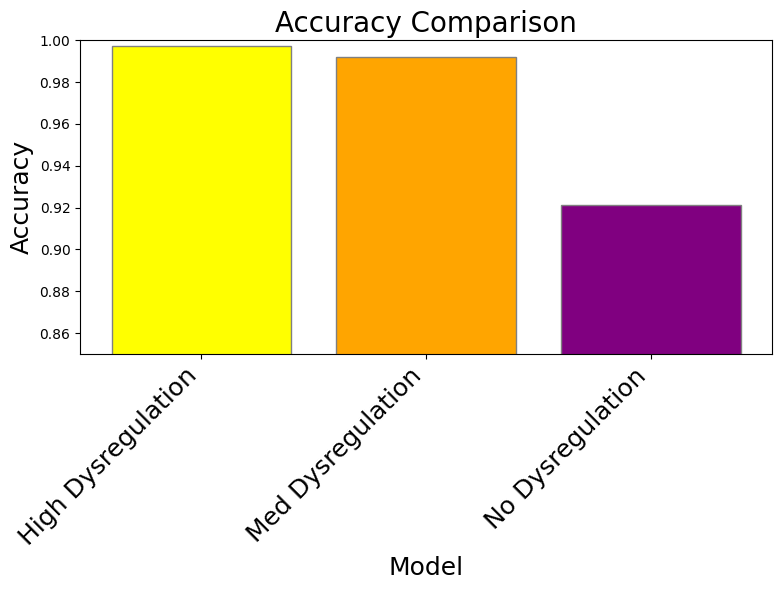

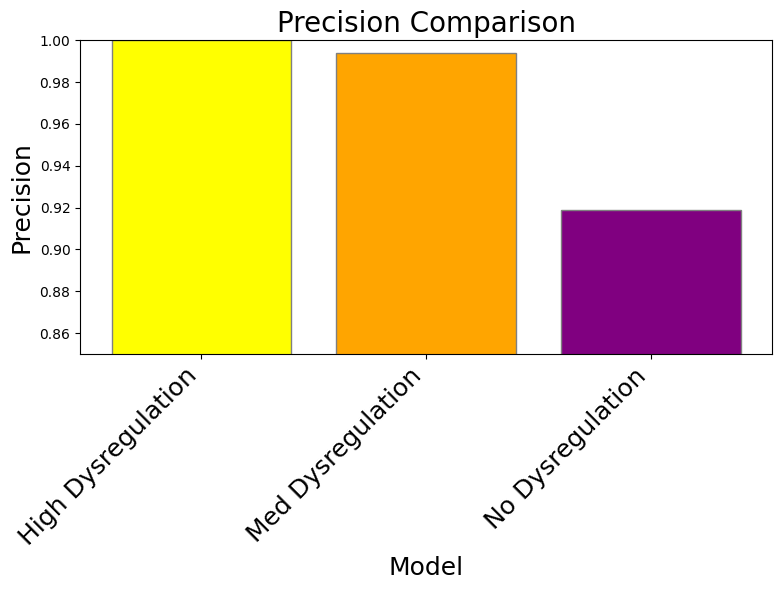

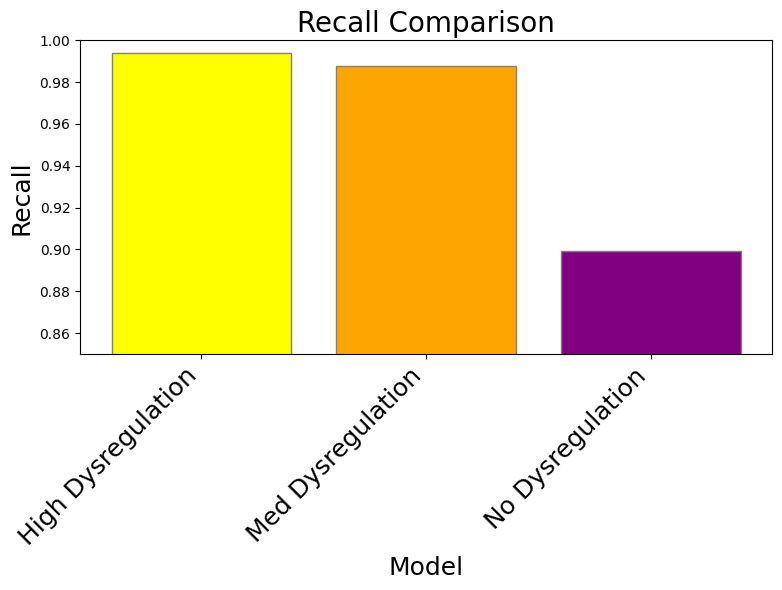

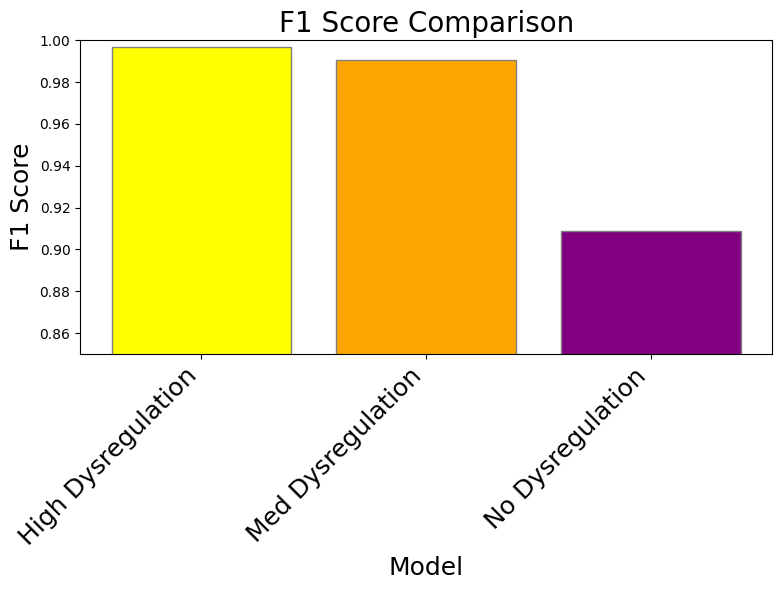

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['High Dysregulation', 'Med Dysregulation', 'No Dysregulation']
accuracies = [accuracy_model1, accuracy_model2, accuracy_model3]
precisions = [precision_model1, precision_model2, precision_model3]
recalls = [recall_model1, recall_model2, recall_model3]
f1_scores = [f1_model1, f1_model2, f1_model3]

# Function to create a bar plot for a given metric with logarithmic scaling and specified colors
def create_bar_plot(metric_values, metric_name):
    plt.figure(figsize=(8, 6))

    # Create bars with scaled heights and specified colors
    plt.bar(model_names, metric_values, color=['yellow', 'orange', 'purple'], edgecolor='grey')
    plt.ylim(0.85, 1.0,)
    plt.title(f'{metric_name} Comparison', fontsize=20)
    plt.xlabel('Model', fontsize=18)
    plt.ylabel(f'{metric_name}', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.tight_layout()
    plt.show()

# Create the four separate plots
create_bar_plot(accuracies, 'Accuracy')
create_bar_plot(precisions, 'Precision')
create_bar_plot(recalls, 'Recall')
create_bar_plot(f1_scores, 'F1 Score')

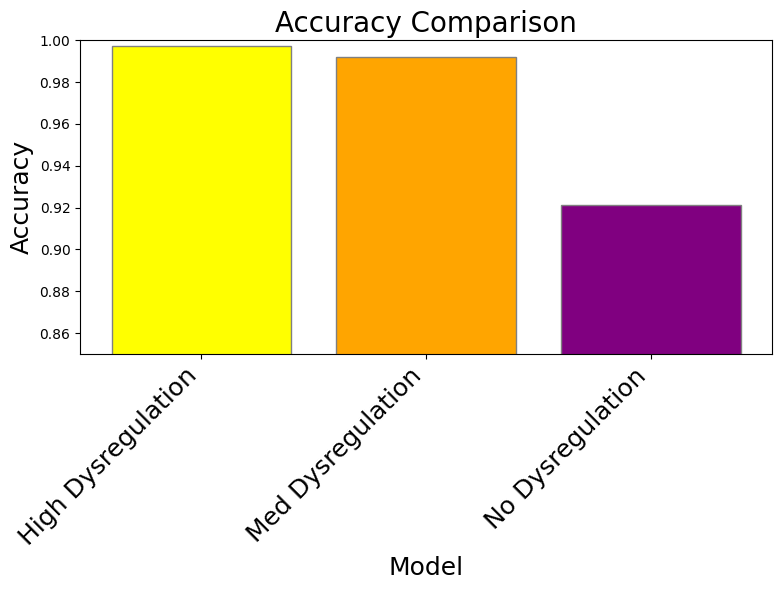

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['High Dysregulation', 'Med Dysregulation', 'No Dysregulation']
accuracies = [accuracy_model1, accuracy_model2, accuracy_model3]
precisions = [precision_model1, precision_model2, precision_model3]
recalls = [recall_model1, recall_model2, recall_model3]
f1_scores = [f1_model1, f1_model2, f1_model3]

# Function to create a bar plot for a given metric with logarithmic scaling and specified colors
def create_bar_plot(metric_values, metric_name):
    plt.figure(figsize=(8, 6))

    # Create bars with scaled heights and specified colors
    plt.bar(model_names, metric_values, color=['yellow', 'orange', 'purple'], edgecolor='grey')
    plt.ylim(0.85, 1.0,)
    plt.title(f'{metric_name} Comparison', fontsize=20)
    plt.xlabel('Model', fontsize=18)
    plt.ylabel(f'{metric_name}', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.tight_layout()
    plt.show()

# Create the four separate plots
create_bar_plot(accuracies, 'Accuracy')
#create_bar_plot(precisions, 'Precision')
#create_bar_plot(recalls, 'Recall')
#create_bar_plot(f1_scores, 'F1 Score')

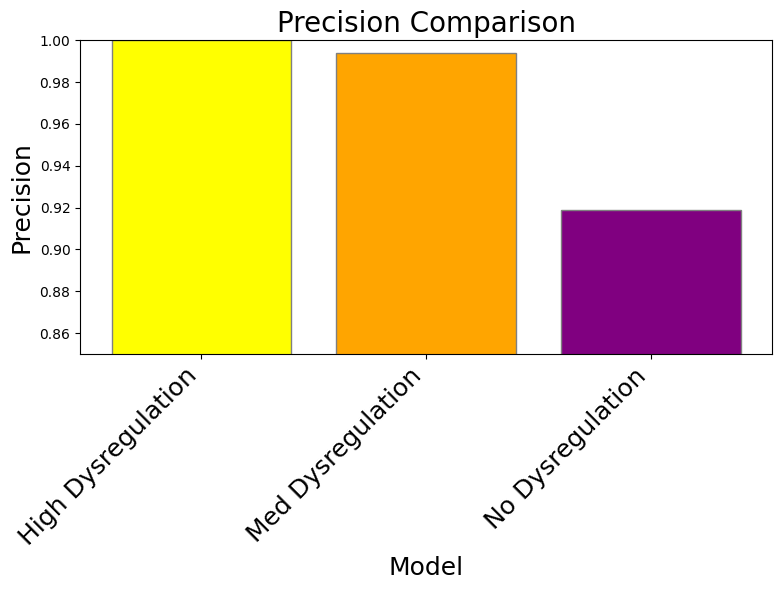

In [ ]:
create_bar_plot(precisions, 'Precision')


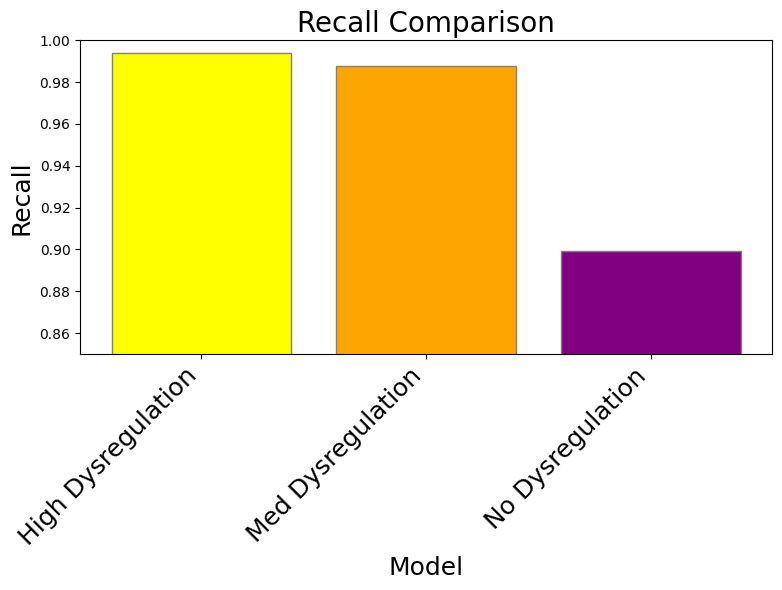

In [ ]:
create_bar_plot(recalls, 'Recall')


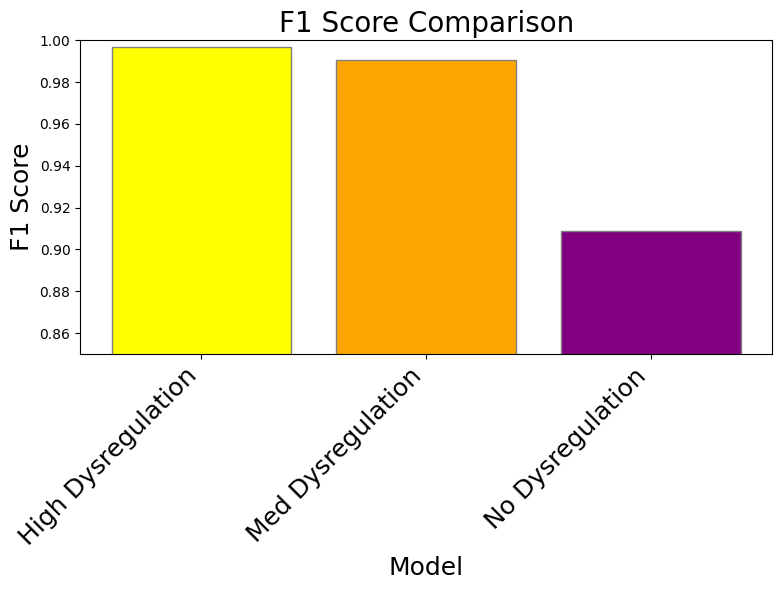

In [ ]:
create_bar_plot(f1_scores, 'F1 Score')


In [ ]:
# --- Model 1 (High Dysregulation) - Combine Dysregulation and Importance ---
importances_model1 = model1.feature_importances_
feature_names_model1 = X_train_model1.columns  # Get feature names
feature_importance_df_model1 = pd.DataFrame({'miRNA': feature_names_model1, 'Importance': importances_model1})

# Merge with dysregulation values for the high dysregulation group
high_dys_combined = pd.merge(high_dysregulation_miRNAs, feature_importance_df_model1, on='miRNA', how='left')

# Rank the miRNAs by importance
high_dys_combined['Importance_Rank'] = high_dys_combined['Importance'].rank(ascending=False)

# --- Model 2 (Low Dysregulation) - Combine Dysregulation and Importance ---
importances_model2 = model2.feature_importances_
feature_names_model2 = X_train_model2.columns  # Get feature names
feature_importance_df_model2 = pd.DataFrame({'miRNA': feature_names_model2, 'Importance': importances_model2})

# Merge with dysregulation values for the low dysregulation group
low_dys_combined = pd.merge(low_dysregulation_miRNAs, feature_importance_df_model2, on='miRNA', how='left')

# Rank the miRNAs by importance
low_dys_combined['Importance_Rank'] = low_dys_combined['Importance'].rank(ascending=False)


# Print combined dataframes (optional)
print("\nHigh Dysregulation miRNAs with Importance and Rank:")
print(high_dys_combined.head())

print("\nLow Dysregulation miRNAs with Importance and Rank:")
print(low_dys_combined.head())


# Save combined dataframes to Excel files
high_dys_combined.to_excel('high_dysregulation_importance.xlsx', index=False)
low_dys_combined.to_excel('low_dysregulation_importance.xlsx', index=False)

from google.colab import files

# Provide download links for the Excel files
files.download('high_dysregulation_importance.xlsx')
files.download('low_dysregulation_importance.xlsx')


High Dysregulation miRNAs with Importance and Rank:
          miRNA  Dysregulation  Importance  Importance_Rank
0  MIMAT0000062       3.443682         NaN              NaN
1  MIMAT0000063       3.039156         NaN              NaN
2  MIMAT0000064       3.663450         NaN              NaN
3  MIMAT0000065       3.080802         NaN              NaN
4  MIMAT0000066       3.083259         NaN              NaN

Low Dysregulation miRNAs with Importance and Rank:
          miRNA  Dysregulation  Importance  Importance_Rank
0  MIMAT0000228       0.720546         NaN              NaN
1  MIMAT0000231       0.710762         NaN              NaN
2  MIMAT0000262       0.816324         NaN              NaN
3  MIMAT0000263       0.821676         NaN              NaN
4  MIMAT0000447       0.948976         NaN              NaN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

df_HIGHDYS = pd.read_csv('HIGHDYS+SEQ.csv')
print(df_HIGHDYS.head()) # To display the first few rows of the DataFrame

df_LOWDYS = pd.read_csv('LOWDYS+SEQ.csv')
print(df_LOWDYS.head()) # To display the first few rows of the DataFrame

              Name                  Sequence
0  hsa-miR-1228-5p     GUGGGCGGGGGCAGGUGUGUG
1  hsa-miR-1238-5p   GUGAGUGGGAGCCCCAGUGUGUG
2     hsa-miR-1246       AAUGGAUUUUUGGAGCAGG
3  hsa-miR-1247-3p  CCCCGGGAACGUCGAGACUGGAGC
4     hsa-miR-1290       UGGAUUUUUGGAUCAGGGA
              Name                Sequence
0  hsa-miR-1225-3p  UGAGCCCCUGUGCCGCCCCCAG
1    hsa-miR-1268a      CGGGCGUGGUGGUGGGGG
2    hsa-miR-1268b    CGGGCGUGGUGGUGGGGGUG
3  hsa-miR-1343-5p  UGGGGAGCGGCCCCCGGGUGGG
4   hsa-miR-149-3p   AGGGAGGGACGGGGGCUGUGC


In [ ]:
!pip install biopython==1.80

from Bio.SeqUtils import GC, molecular_weight
from Bio.Seq import Seq
import collections
import itertools

def calculate_all_descriptors(sequence):
    """Calculates all sequence descriptors, including motif presence.

    Args:
        sequence: The input sequence as a string.

    Returns:
        A dictionary containing all calculated descriptors.
    """
    seq_object = Seq(sequence)
    seq_len = len(sequence)
    base_counts = collections.Counter(sequence.upper())

    descriptors = {
        'length': seq_len,
        'molecular_weight': molecular_weight(seq_object, seq_type="RNA"),  # Specify seq_type as "RNA"
        'A_count': base_counts['A'],
        'U_count': base_counts['U'],
        'C_count': base_counts['C'],
        'G_count': base_counts['G'],
        'A_freq': base_counts['A'] / seq_len,
        'U_freq': base_counts['U'] / seq_len,
        'C_freq': base_counts['C'] / seq_len,
        'G_freq': base_counts['G'] / seq_len,
    }

    # Calculate 2-letter combination counts and frequencies
    for i in range(seq_len - 1):
        dimer = sequence[i:i+2].upper()
        descriptors[f'{dimer}_count'] = sequence.upper().count(dimer)
        descriptors[f'{dimer}_freq'] = sequence.upper().count(dimer) / (seq_len - 1)

    # Generate all possible 3-letter and 4-letter motifs
    # alphabet = "ACGU"
    # all_3_letter_motifs = [''.join(i) for i in itertools.product(alphabet, repeat=3)]
    # all_4_letter_motifs = [''.join(i) for i in itertools.product(alphabet, repeat=4)]

    # Check for presence of each motif
    # for motif in all_3_letter_motifs + all_4_letter_motifs:
    #     descriptors[motif] = 1 if motif in sequence.upper() else 0

    return descriptors


# Now apply this function to your DataFrames
df_HIGHDYS['descriptors'] = df_HIGHDYS['Sequence'].apply(calculate_all_descriptors)
df_HIGHDYS = pd.concat([df_HIGHDYS.drop(['descriptors'], axis=1), df_HIGHDYS['descriptors'].apply(pd.Series)], axis=1)
print(df_HIGHDYS.head)

df_LOWDYS['descriptors'] = df_LOWDYS['Sequence'].apply(calculate_all_descriptors)
df_LOWDYS = pd.concat([df_LOWDYS.drop(['descriptors'], axis=1), df_LOWDYS['descriptors'].apply(pd.Series)], axis=1)
print(df_LOWDYS.head)

from google.colab import files

# Save df_HIGHDYS to a CSV file
df_HIGHDYS.to_csv('df_HIGHDYS.csv', index=False)
files.download('df_HIGHDYS.csv')

# Save df_LOWDYS to a CSV file
df_LOWDYS.to_csv('df_LOWDYS.csv', index=False)
files.download('df_LOWDYS.csv')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.9 MB/s eta 0:00:00
<bound method NDFrame.head of                 Name                   Sequence  length  molecular_weight  \
0    hsa-miR-1228-5p      GUGGGCGGGGGCAGGUGUGUG    21.0         7015.1218   
1    hsa-miR-1238-5p    GUGAGUGGGAGCCCCAGUGUGUG    23.0         7554.4461   
2       hsa-miR-1246        AAUGGAUUUUUGGAGCAGG    19.0         6222.6591   
3    hsa-miR-1247-3p   CCCCGGGAACGUCGAGACUGGAGC    24.0         7824.6741   
4       hsa-miR-1290        UGGAUUUUUGGAUCAGGGA    19.0         6199.6192   
5    hsa-miR-1307-3p     ACUCGGCGUGGCGUCGGUCGUG    22.0         7161.1914   
6    hsa-miR-1343-3p     CUCCUGGGGCCCGCACUCUCGC    22.0         7000.1102   
7      hsa-miR-17-3p     ACUGCAGUGAAGGCACUUGUAG    22.0         7161.2426   
8     hsa-miR-191-5p    CAACGGAAUCCCAAAAGCAGCUG    23.0         7455.4953   
9     hsa-miR-296-3p     GAGGGUUGGGUGGAGGCUCUCC    22.0         7225.2402   
10   hsa-miR-3184-5p   UGAGGGGCCUCAGACCGAGCUUU

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

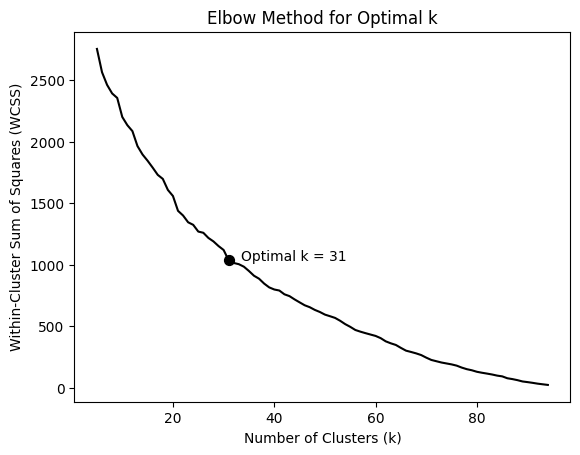

Optimal number of clusters: 31


In [ ]:
import pandas as pd

# Assuming df_highdys and df_lowdys are already loaded
combined_df = pd.concat([df_HIGHDYS, df_LOWDYS], axis=0, ignore_index=True)

from sklearn.preprocessing import StandardScaler

# Select features for clustering
feature_columns = combined_df.columns.difference(['Name', 'Sequence'])
features = combined_df[feature_columns]

# Handle missing values
features = features.fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

from sklearn.cluster import KMeans

# Elbow method
wcss = []
for i in range(5, 95):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(5, 95), wcss, color='black')
plt.title('Elbow Method for Optimal k')  # Optional: Add a title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
optimal_k = 31  # Or use your KneeLocator to find optimal_k
plt.scatter(optimal_k, wcss[optimal_k - 5], color='black', marker='o', s=50)
plt.text(optimal_k + 2.5, wcss[optimal_k - 5], f'Optimal k = {optimal_k}', color='black')
plt.show()

!pip install kneed==0.8.3

from kneed import KneeLocator

k1 = KneeLocator(range(5, 95), wcss, curve="convex", direction="decreasing")
optimal_k = k1.elbow
print("Optimal number of clusters:", optimal_k)

# Apply KMeans with chosen k
k = 31
kmeans = KMeans(n_clusters=k, random_state=42)
combined_df['cluster'] = kmeans.fit_predict(scaled_features)


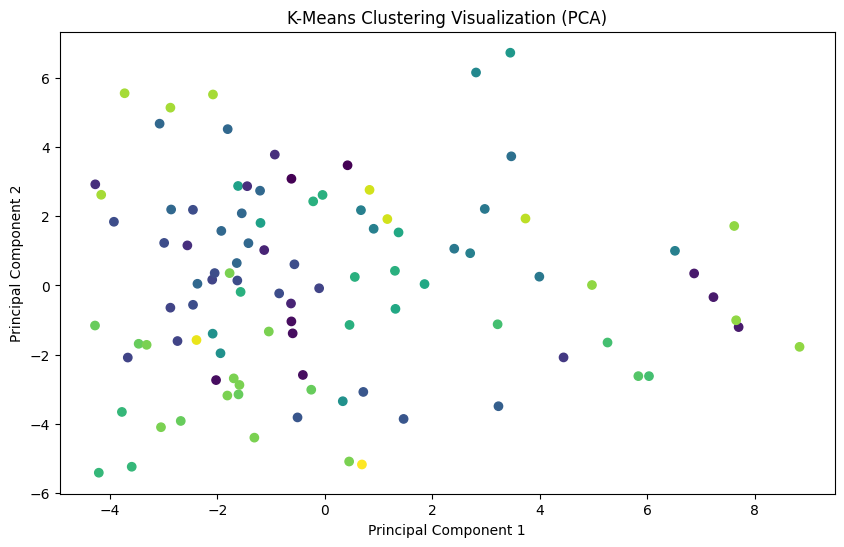

<ipython-input-17-7a84f2c9b095>:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(high_dys_data['PC1'], high_dys_data['PC2'],


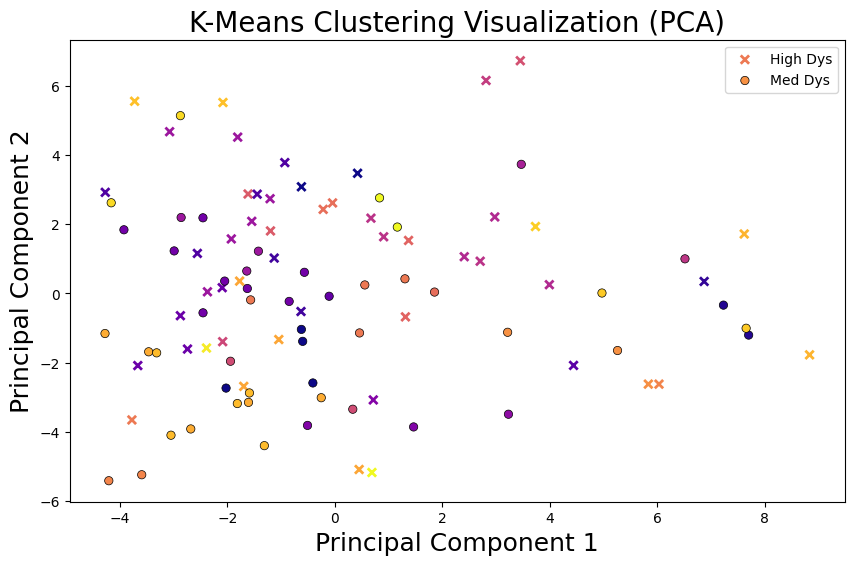

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have 'combined_df' with 'cluster' column and scaled features

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = combined_df['cluster']

# Plot clusters with color representing cluster assignments
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis')
plt.title('K-Means Clustering Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot clusters with color representing cluster assignments and markers for dysregulation
plt.figure(figsize=(10, 6))

# Separate data points for high and low dysregulation
high_dys_data = pca_df[combined_df['dys_dataset'] == 'High Dys']
low_dys_data = pca_df[combined_df['dys_dataset'] == 'Med Dys']  # Changed to 'Med Dys'

# Plot high dysregulation miRNAs with 'H' marker
plt.scatter(high_dys_data['PC1'], high_dys_data['PC2'],
            c=high_dys_data['cluster'], cmap='plasma', marker='x', edgecolors='black', linewidths=2.00, label='High Dys')

# Plot low dysregulation miRNAs with 'L' marker (using a different marker style)
plt.scatter(low_dys_data['PC1'], low_dys_data['PC2'],
            c=low_dys_data['cluster'], cmap='plasma', marker='o', edgecolors='black', linewidths=0.50, label='Med Dys')  # Changed marker to 'o'

plt.title('K-Means Clustering Visualization (PCA)',fontsize=20)
plt.xlabel('Principal Component 1',fontsize=18)
plt.ylabel('Principal Component 2',fontsize=18)
plt.legend()
plt.show()

<ipython-input-26-27cf7f81d968>:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(high_dys_data['PC1'], high_dys_data['PC2'],


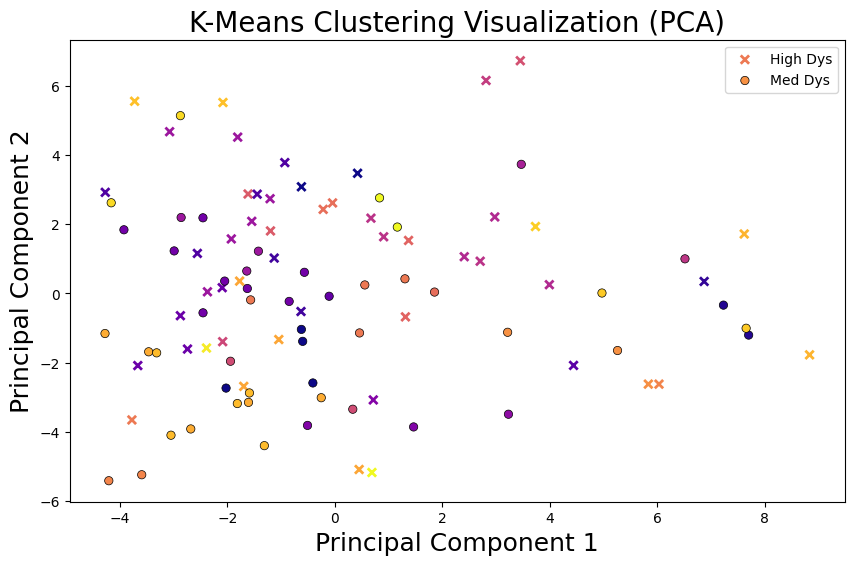

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have 'combined_df' with 'cluster' column and scaled features

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = combined_df['cluster']

## Plot clusters with color representing cluster assignments
#plt.figure(figsize=(10, 6))
#plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis')
#plt.title('K-Means Clustering Visualization (PCA)')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.show()

# Plot clusters with color representing cluster assignments and markers for dysregulation
plt.figure(figsize=(10, 6))

# Separate data points for high and low dysregulation
high_dys_data = pca_df[combined_df['dys_dataset'] == 'High Dys']
low_dys_data = pca_df[combined_df['dys_dataset'] == 'Med Dys']  # Changed to 'Med Dys'

# Plot high dysregulation miRNAs with 'H' marker
plt.scatter(high_dys_data['PC1'], high_dys_data['PC2'],
            c=high_dys_data['cluster'], cmap='plasma', marker='x', edgecolors='black', linewidths=2.00, label='High Dys')

# Plot low dysregulation miRNAs with 'L' marker (using a different marker style)
plt.scatter(low_dys_data['PC1'], low_dys_data['PC2'],
            c=low_dys_data['cluster'], cmap='plasma', marker='o', edgecolors='black', linewidths=0.50, label='Med Dys')  # Changed marker to 'o'

plt.title('K-Means Clustering Visualization (PCA)',fontsize=20)
plt.xlabel('Principal Component 1',fontsize=18)
plt.ylabel('Principal Component 2',fontsize=18)
plt.legend()
plt.show()

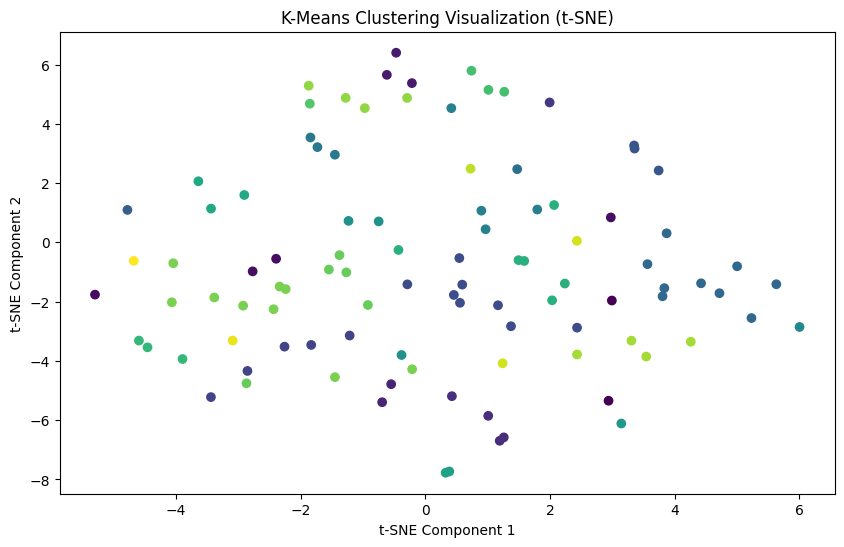

<ipython-input-16-264fbd091ee8>:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(high_dys_data['t-SNE1'], high_dys_data['t-SNE2'],


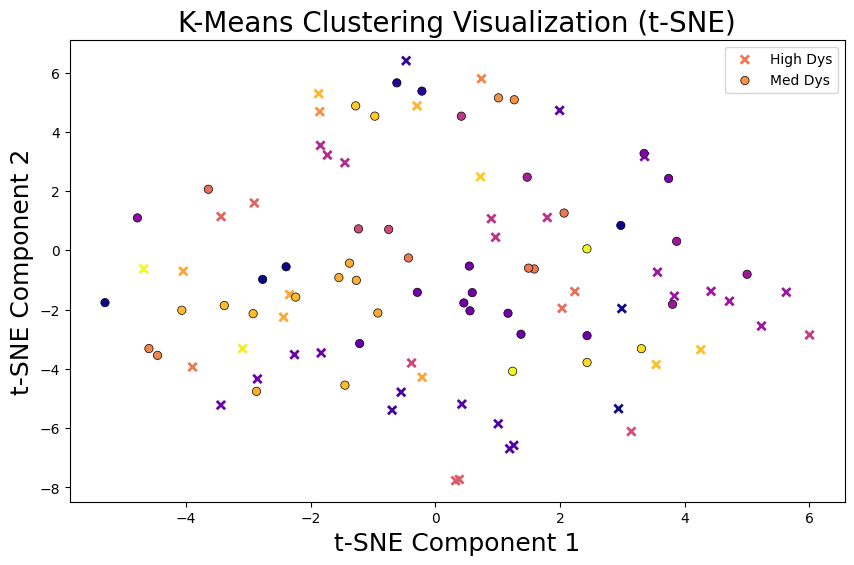

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality to 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE1', 't-SNE2'])
tsne_df['cluster'] = combined_df['cluster']

# Plot clusters with color representing cluster assignments
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['cluster'], cmap='viridis')
plt.title('K-Means Clustering Visualization (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Plot clusters with color representing cluster assignments and markers for dysregulation
plt.figure(figsize=(10, 6))

# Separate data points for high and low dysregulation
high_dys_data = tsne_df[combined_df['dys_dataset'] == 'High Dys']
low_dys_data = tsne_df[combined_df['dys_dataset'] == 'Med Dys']  # Changed to 'Med Dys'

# Plot high dysregulation miRNAs with 'H' marker
plt.scatter(high_dys_data['t-SNE1'], high_dys_data['t-SNE2'],
            c=high_dys_data['cluster'], cmap='plasma', marker='x', edgecolors='black', linewidths=2.00, label='High Dys')

# Plot low dysregulation miRNAs with 'L' marker (using a different marker style)
plt.scatter(low_dys_data['t-SNE1'], low_dys_data['t-SNE2'],
            c=low_dys_data['cluster'], cmap='plasma', marker='o', edgecolors='black', linewidths=0.5, label='Med Dys')  # Changed marker to 'o'

plt.title('K-Means Clustering Visualization (t-SNE)',fontsize=20)
plt.xlabel('t-SNE Component 1',fontsize=18)
plt.ylabel('t-SNE Component 2',fontsize=18)
plt.legend()
plt.show()

<ipython-input-25-2592d0ea08af>:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(high_dys_data['t-SNE1'], high_dys_data['t-SNE2'],


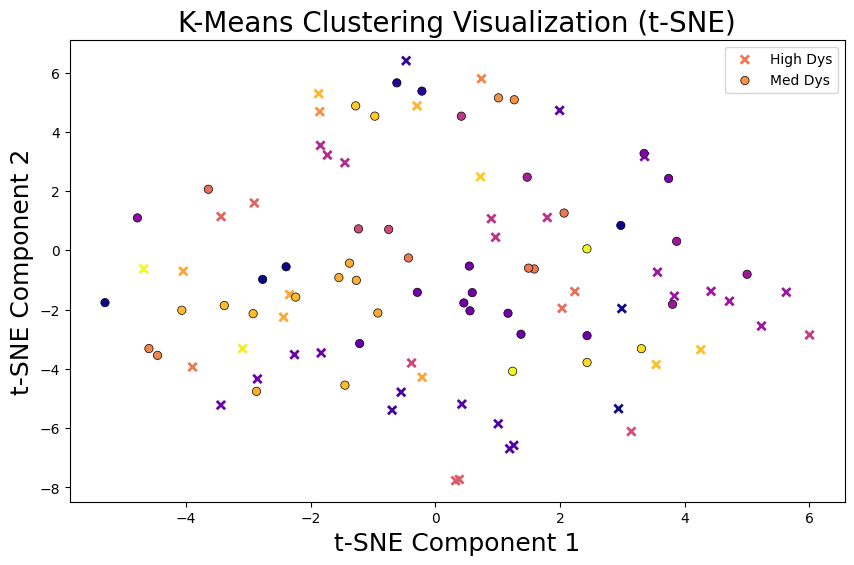

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality to 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE1', 't-SNE2'])
tsne_df['cluster'] = combined_df['cluster']

## Plot clusters with color representing cluster assignments
#plt.figure(figsize=(10, 6))
#plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['cluster'], cmap='viridis')
#plt.title('K-Means Clustering Visualization (t-SNE)')
#plt.xlabel('t-SNE Component 1')
#plt.ylabel('t-SNE Component 2')
#plt.show()

# Plot clusters with color representing cluster assignments and markers for dysregulation
plt.figure(figsize=(10, 6))

# Separate data points for high and low dysregulation
high_dys_data = tsne_df[combined_df['dys_dataset'] == 'High Dys']
low_dys_data = tsne_df[combined_df['dys_dataset'] == 'Med Dys']  # Changed to 'Med Dys'

# Plot high dysregulation miRNAs with 'H' marker
plt.scatter(high_dys_data['t-SNE1'], high_dys_data['t-SNE2'],
            c=high_dys_data['cluster'], cmap='plasma', marker='x', edgecolors='black', linewidths=2.00, label='High Dys')

# Plot low dysregulation miRNAs with 'L' marker (using a different marker style)
plt.scatter(low_dys_data['t-SNE1'], low_dys_data['t-SNE2'],
            c=low_dys_data['cluster'], cmap='plasma', marker='o', edgecolors='black', linewidths=0.5, label='Med Dys')  # Changed marker to 'o'

plt.title('K-Means Clustering Visualization (t-SNE)',fontsize=20)
plt.xlabel('t-SNE Component 1',fontsize=18)
plt.ylabel('t-SNE Component 2',fontsize=18)
plt.legend()
plt.show()

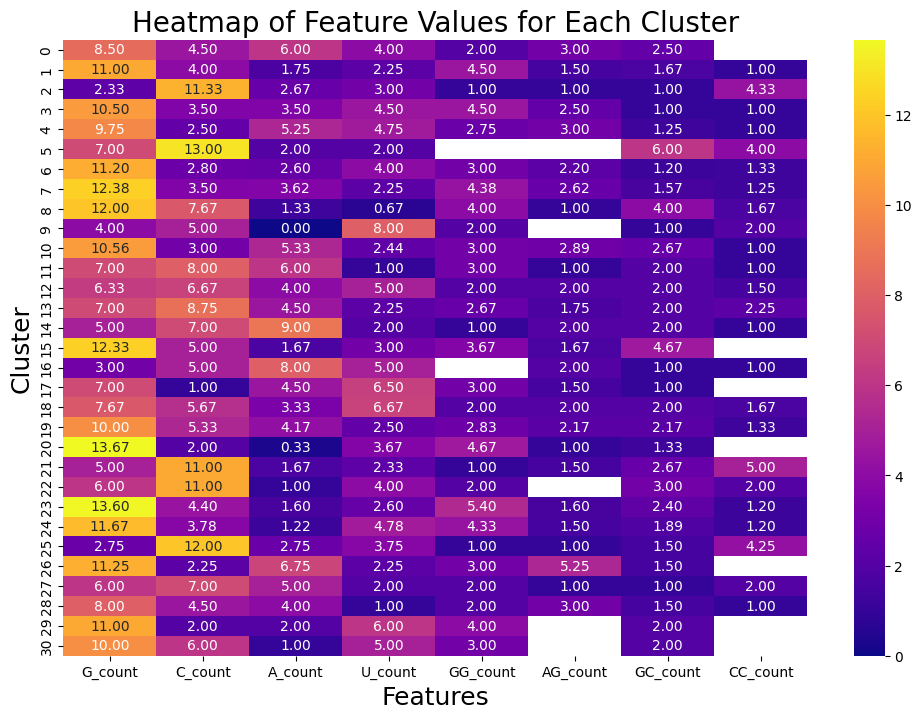

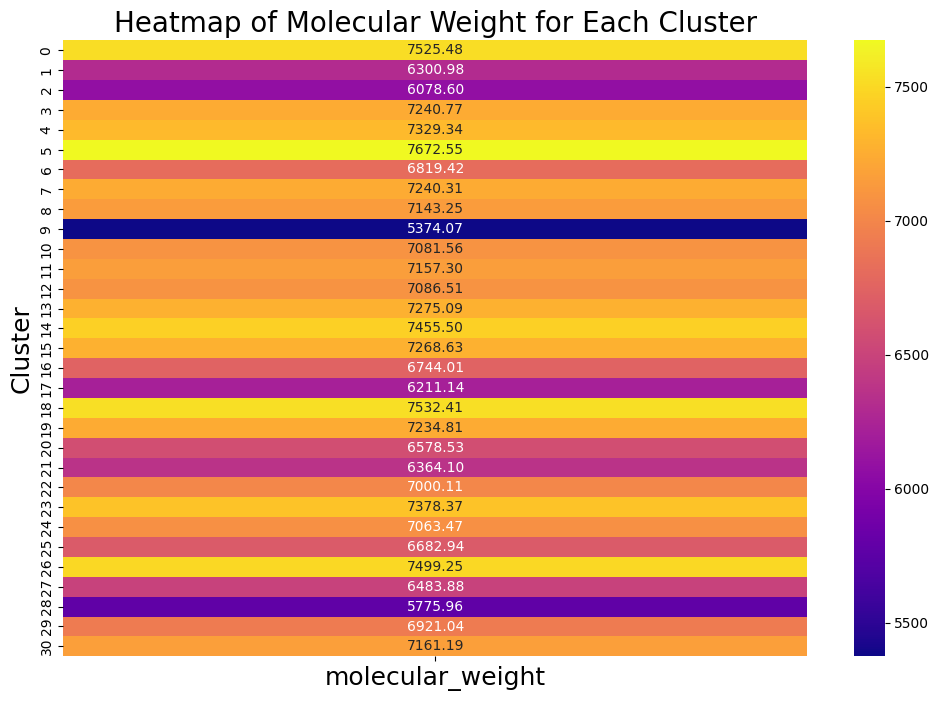

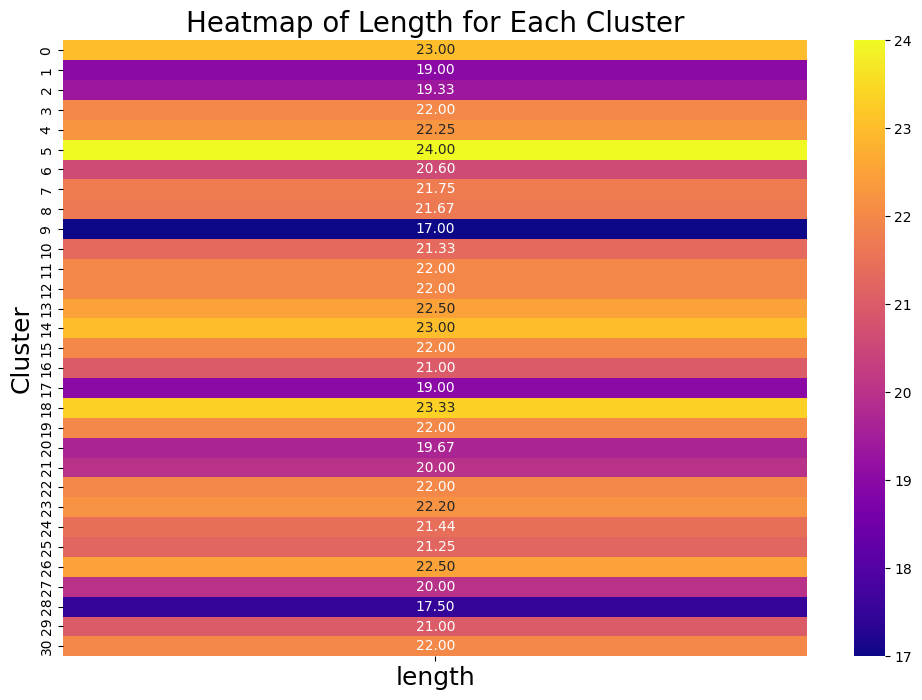

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Select top features (including molecular weight and length)
top_features = combined_df[feature_columns].mean().sort_values(ascending=False).head(10).index

# Create heatmap data for all top features (including molecular weight and length)
cluster_heatmap_data = combined_df.groupby('cluster')[top_features].mean()

# 1. Heatmap for all features except "molecular_weight" and "length"

# Create a copy of the data and drop the "molecular_weight" and "length" columns
heatmap1_data = cluster_heatmap_data.drop(columns=['molecular_weight', 'length'], errors='ignore')

# Create the first heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap1_data, annot=True, cmap='plasma', fmt=".2f", yticklabels=cluster_heatmap_data.index)
plt.title('Heatmap of Feature Values for Each Cluster',fontsize=20)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Cluster',fontsize=18)
plt.show()

# 2. Heatmap for "molecular_weight" only

# Select only the "molecular_weight" column
mw_data = cluster_heatmap_data[['molecular_weight']]

# Create the second heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mw_data, annot=True, cmap='plasma', fmt=".2f")
plt.title('Heatmap of Molecular Weight for Each Cluster',fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Cluster',fontsize=18)
plt.show()

# 3. Heatmap for "length" only

# Select only the "length" column
length_data = cluster_heatmap_data[['length']]

# Create the third heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(length_data, annot=True, cmap='plasma', fmt=".2f")
plt.title('Heatmap of Length for Each Cluster',fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Cluster',fontsize=18)
plt.show()

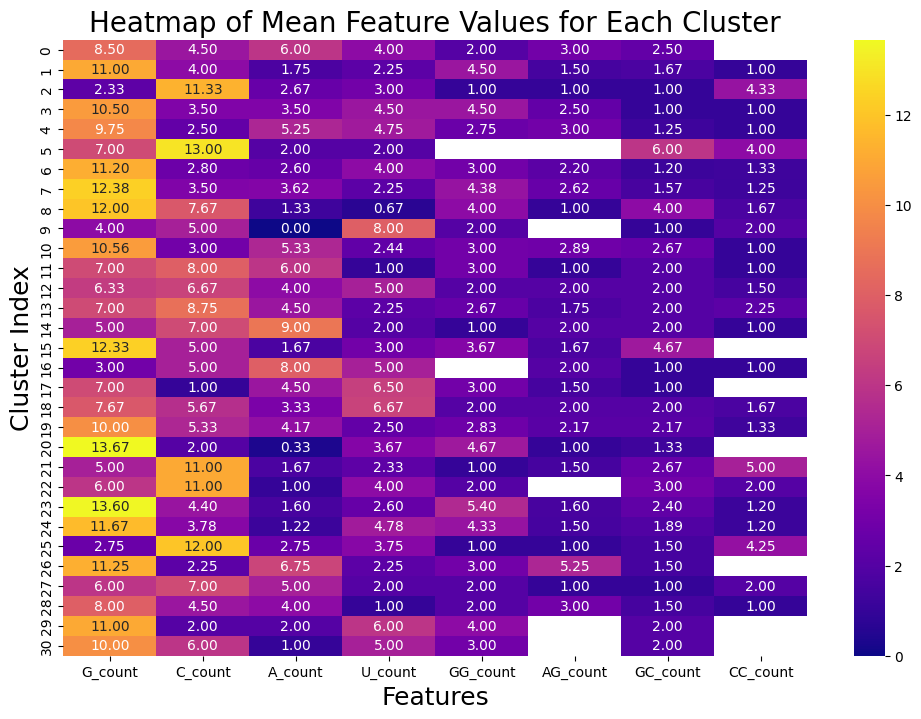

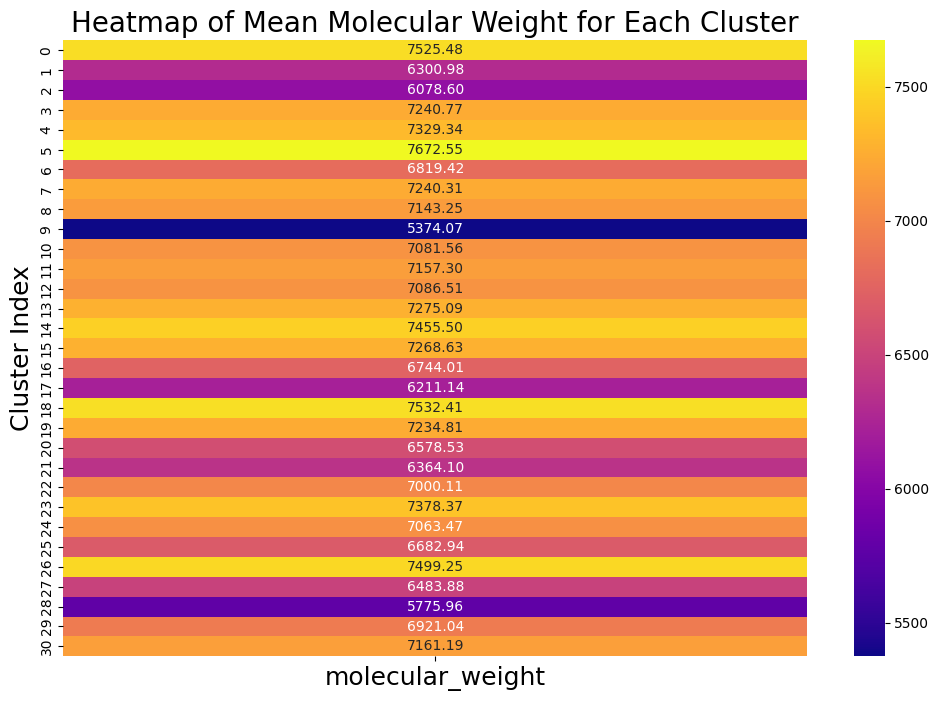

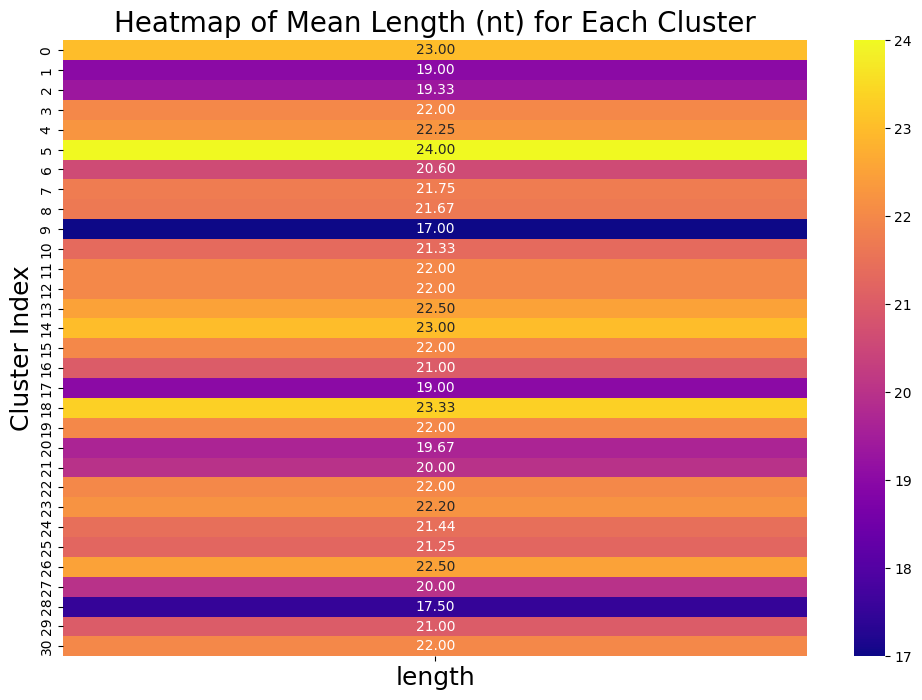

In [ ]:
# 1. Heatmap for all features except "molecular_weight" and "length"

## Create a copy of the data and drop the "molecular_weight" and "length" columns
#heatmap1_data = cluster_heatmap_data.drop(columns=['molecular_weight', 'length'], errors='ignore')

# Create the first heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap1_data, annot=True, cmap='plasma', fmt=".2f", yticklabels=cluster_heatmap_data.index)
plt.title('Heatmap of Mean Feature Values for Each Cluster',fontsize=20)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Cluster Index',fontsize=18)
plt.show()

# 2. Heatmap for "molecular_weight" only

## Select only the "molecular_weight" column
#mw_data = cluster_heatmap_data[['molecular_weight']]

# Create the second heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mw_data, annot=True, cmap='plasma', fmt=".2f")
plt.title('Heatmap of Mean Molecular Weight for Each Cluster',fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Cluster Index',fontsize=18)
plt.show()

# 3. Heatmap for "length" only

## Select only the "length" column
#length_data = cluster_heatmap_data[['length']]

# Create the third heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(length_data, annot=True, cmap='plasma', fmt=".2f")
plt.title('Heatmap of Mean Length (nt) for Each Cluster',fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Cluster Index',fontsize=18)
plt.show()

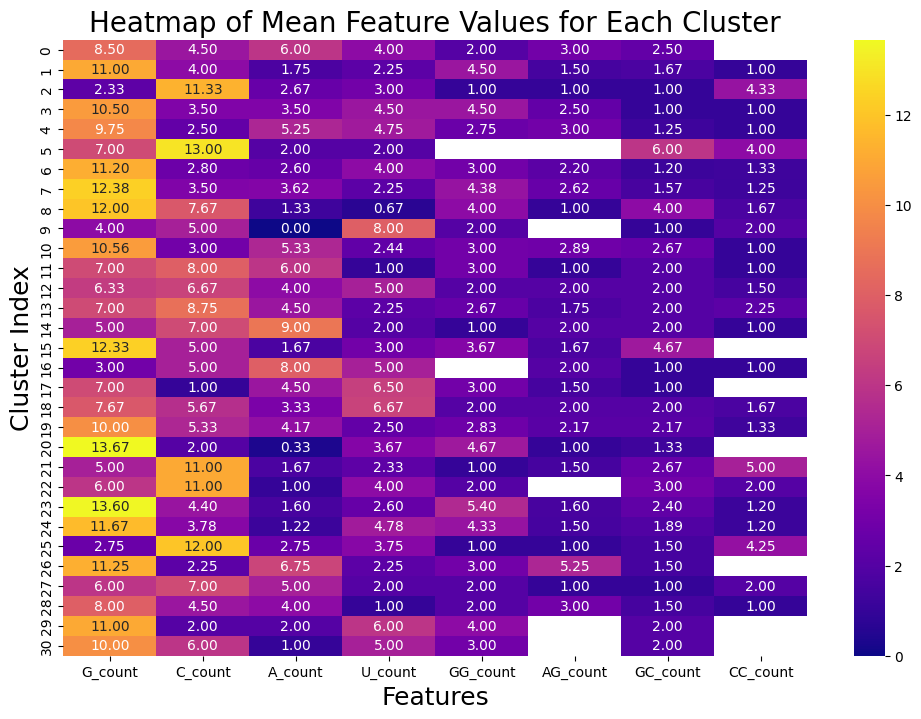

In [ ]:
# 1. Heatmap for all features except "molecular_weight" and "length"

## Create a copy of the data and drop the "molecular_weight" and "length" columns
#heatmap1_data = cluster_heatmap_data.drop(columns=['molecular_weight', 'length'], errors='ignore')

# Create the first heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap1_data, annot=True, cmap='plasma', fmt=".2f", yticklabels=cluster_heatmap_data.index)
plt.title('Heatmap of Mean Feature Values for Each Cluster',fontsize=20)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Cluster Index',fontsize=18)
plt.show()


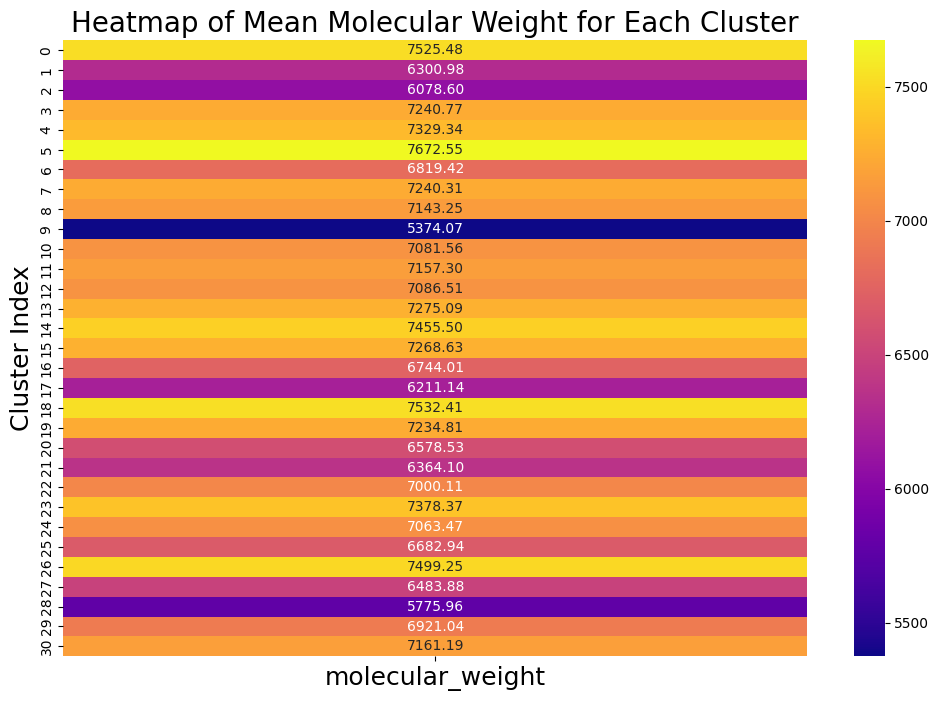

In [ ]:
# 2. Heatmap for "molecular_weight" only

## Select only the "molecular_weight" column
#mw_data = cluster_heatmap_data[['molecular_weight']]

# Create the second heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mw_data, annot=True, cmap='plasma', fmt=".2f")
plt.title('Heatmap of Mean Molecular Weight for Each Cluster',fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Cluster Index',fontsize=18)
plt.show()


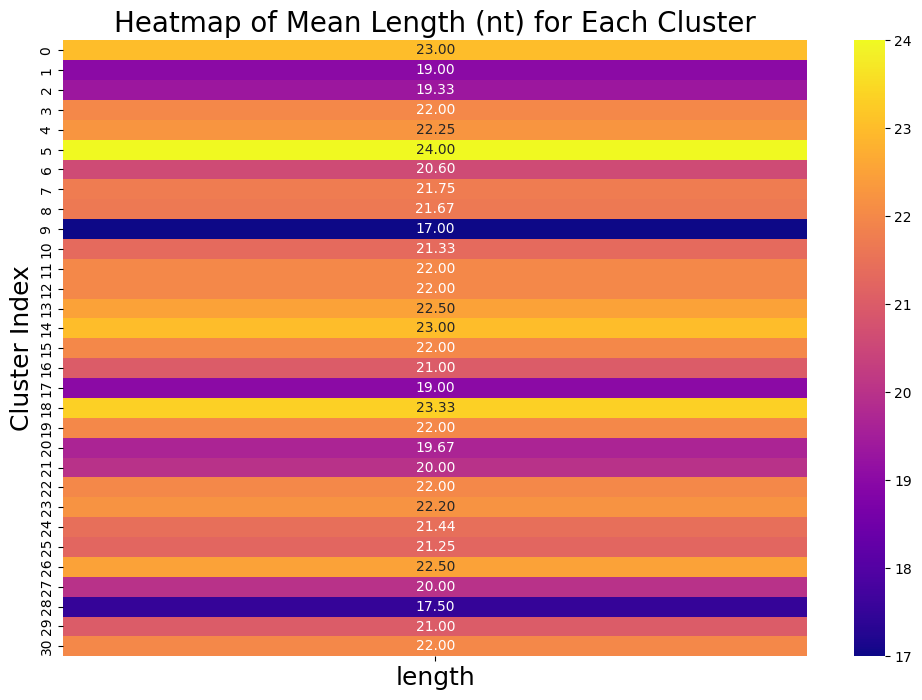

In [ ]:
# 3. Heatmap for "length" only

## Select only the "length" column
#length_data = cluster_heatmap_data[['length']]

# Create the third heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(length_data, annot=True, cmap='plasma', fmt=".2f")
plt.title('Heatmap of Mean Length (nt) for Each Cluster',fontsize=20)
plt.xticks(fontsize=18)
plt.ylabel('Cluster Index',fontsize=18)
plt.show()


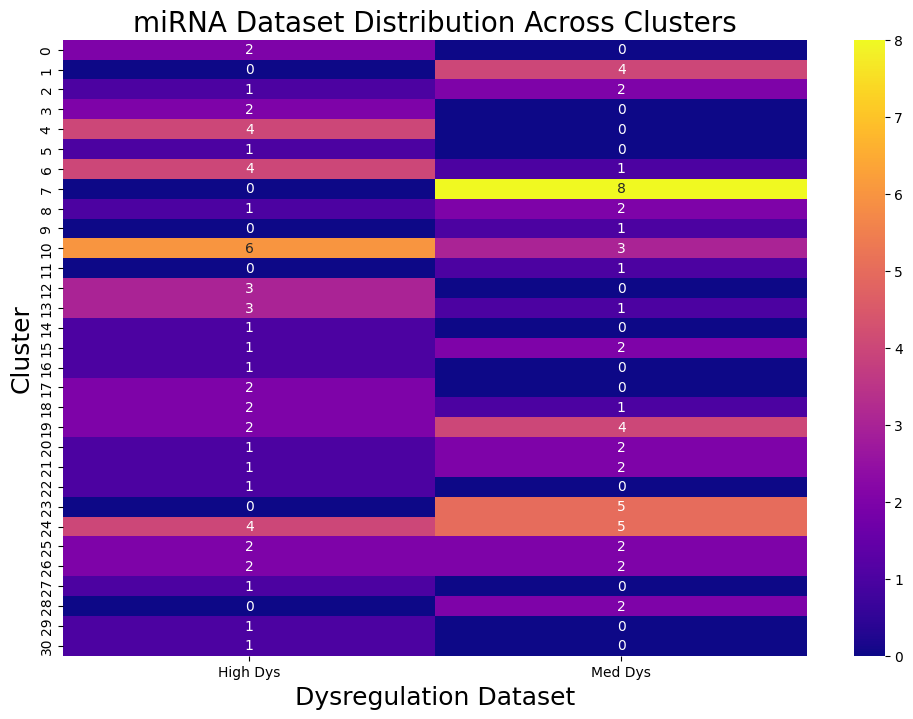

In [ ]:
import pandas as pd

# Load the sequence data
df_highdys = pd.read_csv('HIGHDYS+SEQ.csv')
df_lowdys = pd.read_csv('LOWDYS+SEQ.csv')

# Create a 'dys_dataset' column in each DataFrame
df_highdys['dys_dataset'] = 'High Dys'
df_lowdys['dys_dataset'] = 'Med Dys'

# Concatenate the DataFrames
all_dys_df = pd.concat([df_highdys, df_lowdys], ignore_index=True)

# Merge with the combined_df
combined_df = pd.merge(combined_df, all_dys_df[['Name', 'dys_dataset']], on='Name', how='left')

import seaborn as sns
import matplotlib.pyplot as plt

# Create a contingency table (cluster vs. dys_dataset)
contingency_table = pd.crosstab(combined_df['cluster'], combined_df['dys_dataset'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap="plasma", fmt="d")
plt.title("miRNA Dataset Distribution Across Clusters", fontsize=20)
plt.xlabel("Dysregulation Dataset", fontsize=18)
plt.ylabel("Cluster", fontsize=18)
plt.show()

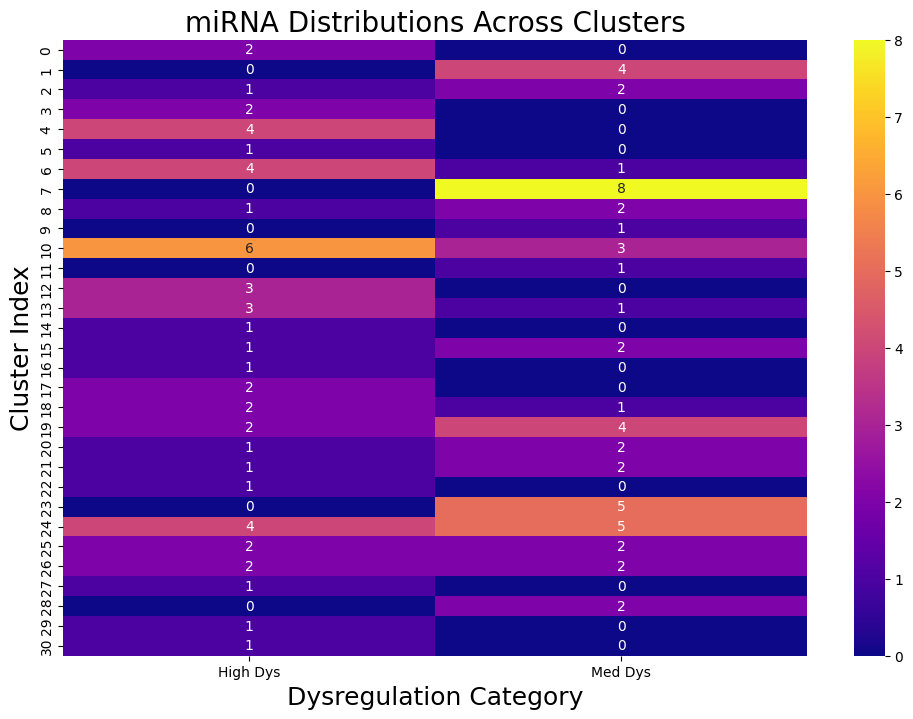

In [ ]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap="plasma", fmt="d")
plt.title("miRNA Distributions Across Clusters", fontsize=20)
plt.xlabel("Dysregulation Category", fontsize=18)
plt.ylabel("Cluster Index", fontsize=18)
plt.show()

In [ ]:
import pandas as pd
from scipy import stats
from google.colab import files

# Assuming your DataFrame 'df' is already loaded and contains '!Sample_characteristics_ch1' and miRNA columns

# Assuming results_df is already defined and contains 'p_value' and 't_statistic' columns

p_value_threshold = 0.001
t_statistic_threshold_positive = 10
t_statistic_threshold_negative = -10

# Filter based on probability thresholds (p-value and t-statistic)
filtered_miRNAs_by_probability = results_df[
    (results_df['p_value'] < p_value_threshold) &
    ((results_df['t_statistic'] > t_statistic_threshold_positive) |
     (results_df['t_statistic'] < t_statistic_threshold_negative))
]

# Count the number of filtered miRNAs
num_filtered_miRNAs = filtered_miRNAs_by_probability.shape[0]
num_unfiltered_miRNAs = results_df.shape[0] - num_filtered_miRNAs

print(f"Number of miRNAs meeting the probability thresholds: {num_filtered_miRNAs}")
print(f"Number of miRNAs not meeting the probability thresholds: {num_unfiltered_miRNAs}")

# Select all miRNAs with their t_statistic and p_value
all_miRNAs_output = results_df[['t_statistic', 'p_value']].reset_index()
all_miRNAs_output.rename(columns={'index': 'miRNA'}, inplace=True)

# Save all miRNAs to an Excel file
excel_filename = 'all_miRNAs_with_stats.xlsx'
all_miRNAs_output.to_excel(excel_filename, index=False)

print(f"\nAll miRNAs with their statistics saved to '{excel_filename}'")

# Provide download link
files.download(excel_filename)

Number of miRNAs meeting the probability thresholds: 2170
Number of miRNAs not meeting the probability thresholds: 395

All miRNAs with their statistics saved to 'all_miRNAs_with_stats.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Print the number of miRNAs in each set
print(f"Number of High Dysregulation miRNAs: {high_dysregulation_miRNAs.shape[0]}")
print(f"Number of Low Dysregulation miRNAs: {low_dysregulation_miRNAs.shape[0]}")
print(f"Number of No Dysregulation miRNAs: {no_dysregulation_miRNAs.shape[0]}")


# Save each dysregulation group to a separate Excel file
high_dysregulation_miRNAs.to_excel('high_dysregulation_miRNAs.xlsx', index=False)
low_dysregulation_miRNAs.to_excel('low_dysregulation_miRNAs.xlsx', index=False)
no_dysregulation_miRNAs.to_excel('no_dysregulation_miRNAs.xlsx', index=False)

from google.colab import files

# Provide download links for each file
files.download('high_dysregulation_miRNAs.xlsx')
files.download('low_dysregulation_miRNAs.xlsx')
files.download('no_dysregulation_miRNAs.xlsx')

Number of High Dysregulation miRNAs: 1818
Number of Low Dysregulation miRNAs: 344
Number of No Dysregulation miRNAs: 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>